# <center> <b> <font color='#154360'> WIDE AND DEEP MODEL </font> </b> </center>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)  
3. [Data](#3)
4. [Model](#4)
5. [Training](#5)
6. [Predictions](#6)
7. [References](#references)

<a name="1"></a>
## <font color='blue'> 1. Introduction </font>
    
In this notebook, we will explore how to build a **custom model** in TensorFlow using the **Wide and Deep architecture**. The goal is to demonstrate how to go beyond pre-built models by leveraging TensorFlow's flexibility to create tailored architectures that fit specific use cases.

The **Wide and Deep Model** is a hybrid neural network that combines the benefits of both **memorization** (wide part) and **generalization** (deep part). Initially introduced by Google for recommendation systems, this architecture is particularly effective in scenarios where the data consists of both **sparse features** (e.g., categorical variables) and **dense features** (e.g., continuous variables).


<a name="2"></a>
## <font color='blue'> 2. Setup </font>

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
import numpy as np
import random

In [39]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

<a name="3"></a>
## <font color='blue'> 3. Data </font>

To test the model we will generate synthetic data.

In [41]:
# Generate synthetic data for testing
num_samples = 1000  # Number of samples

# Create random data for input_A and input_B (e.g., 10 features each)
input_A_data = np.random.rand(num_samples, 10)  # Shape (1000, 10)
input_B_data = np.random.rand(num_samples, 20)  # Shape (1000, 20)

# Generate random labels for the main and auxiliary outputs
main_output_data = np.random.rand(num_samples, 1)  # Shape (1000, 1)
aux_output_data = np.random.rand(num_samples, 1)   # Shape (1000, 1)

<a name="4"></a>
## <font color='blue'> 4. Model </font>

We will implement the following model:

<br>
    
<img src="images/wide_deep.png"/>

Firts, we will use the Functional API:

In [42]:
def build_compile_model(num_wide_features, num_deep_features):
    # define inputs
    input_wide = Input(shape=(num_wide_features, ), name="Wide_Input")
    input_deep = Input(shape=(num_deep_features, ), name="Deep_Input")

    # define deep path
    hidden_1 = Dense(30, activation="relu")(input_deep)
    hidden_2 = Dense(30, activation="relu")(hidden_1)

    # define merged path
    concat = concatenate([input_wide, hidden_2])
    output = Dense(1, name="Output")(concat)

    # define another output for the deep path
    aux_output = Dense(1,name="aux_Output")(hidden_2)

    # build the model
    model = Model(inputs=[input_wide, input_deep], outputs=[output, aux_output])
    
    # return
    return model
    

In [43]:
model = build_compile_model(1, 1)

In [44]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Deep_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense_46 (Dense)            (None, 30)                   60        ['Deep_Input[0][0]']          
                                                                                                  
 Wide_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense_47 (Dense)            (None, 30)                   930       ['dense_46[0][0]']            
                                                                                           

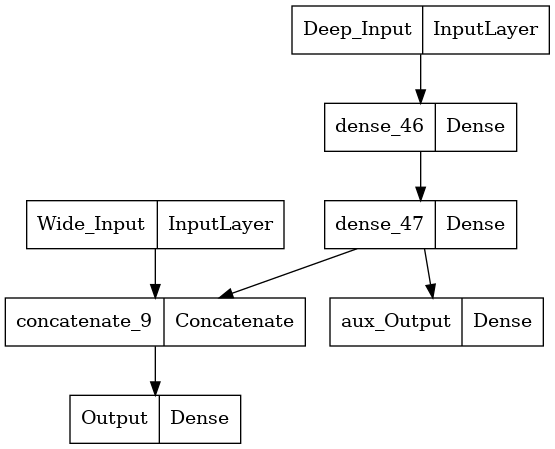

In [45]:
plot_model(model)

Now, we will implement it as a class.

To do this, we define a class that inherits from the Model class.
By inheriting from the Model class, we can use built-in methods like compile(), fit(), and evaluate().


When subclassing Model, we need to define at least two methods:

- ```__init__():``` 
    - Where we initialize the instance attributes and set up the layers.
    
    
- call(): 
    - Where we build the forward pass by connecting the layers and returning the output.

While the overall structure stays similar to other approaches, using a class allows us to define all the layers in ```__init__``` and then connect them in call, giving us more flexibility when designing custom architectures.



In [46]:
class WideAndDeepModel(Model):
    """
    A model that combines the Wide and Deep learning architectures.
    
    The model has two hidden layers, one for the deep part (input_B) and one for the wide part (input_A).
    It outputs two predictions: the main output and an auxiliary output. This model is designed for use cases
    that benefit from both wide and deep learning components.
    """

    def __init__(self, units=30, activation='relu', **kwargs):
        """
        Initializes the instance attributes.
        
        Args:
            units (int): The number of units in the hidden layers.
            activation (str): The activation function for the hidden layers.
            **kwargs: Additional arguments passed to the base class `Model`.
        """
        super().__init__(**kwargs)  # Initialize the parent Model class
        self.hidden1 = Dense(units, activation=activation)  # First hidden layer (deep part)
        self.hidden2 = Dense(units, activation=activation)  # Second hidden layer (deep part)
        self.main_output = Dense(1)  # Main output layer
        self.aux_output = Dense(1)  # Auxiliary output layer

    def call(self, inputs):
        """
        Defines the forward pass of the model, specifying how the data flows through the network.
        
        Args:
            inputs (list): A list of two inputs: input_A and input_B.
        
        Returns:
            tuple: A tuple containing the main output and auxiliary output.
        """
        input_A, input_B = inputs  # Unpack the inputs
        hidden1 = self.hidden1(input_B)  # Pass input_B through the first hidden layer
        hidden2 = self.hidden2(hidden1)  # Pass the result through the second hidden layer
        concat = concatenate([input_A, hidden2])  # Concatenate input_A with the deep network output
        main_output = self.main_output(concat)  # Compute the main output
        aux_output = self.aux_output(hidden2)  # Compute the auxiliary output
        
        return main_output, aux_output  # Return both outputs


<a name="5"></a>
## <font color='blue'> 5. Training </font>

Let's train our model.

In [49]:
# Define the input layers for the model
input_A = Input(shape=(input_A_data.shape[1],))  # 10 features
input_B = Input(shape=(input_B_data.shape[1],))  # 20 features

# Initialize the model
model = WideAndDeepModel(units=64, activation='relu')

# Define the model's inputs and outputs
main_output, aux_output = model([input_A, input_B])

# Create the final model
final_model = Model(inputs=[input_A, input_B], outputs=[main_output, aux_output])

# Compile the model
final_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train the model with the synthetic data
final_model.fit([input_A_data, input_B_data], [main_output_data, aux_output_data], 
                 verbose=0, epochs=10, batch_size=32)

<a name="6"></a>
## <font color='blue'> 6. Predictions </font>

Finally, let's make predictions.

In [48]:
# Generate new synthetic data for prediction
new_input_A = np.random.rand(5, 10)  # 5 new samples for input A
new_input_B = np.random.rand(5, 20)  # 5 new samples for input B

# Make predictions
predictions = final_model.predict([new_input_A, new_input_B])

# Display predictions
main_pred, aux_pred = predictions
print("Main Output Predictions:\n", main_pred)
print("\nAuxiliary Output Predictions:\n", aux_pred)

1/1 [==============================] - 0s 75ms/step
Main Output Predictions:
 [[0.29950747]
 [0.44180724]
 [0.25185195]
 [0.56478745]
 [0.45130977]]

Auxiliary Output Predictions:
 [[0.41137284]
 [0.47043952]
 [0.50082964]
 [0.40682563]
 [0.4181565 ]]


<a name="references"></a>
## <font color='blue'> 7. References </font>

[TensorFlow Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)
